In [1]:

%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [7]:
1e-11*(38000**2)/(86400)

1.6712962962962963e-07

In [101]:
## Gustavo's default KHTH=300
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH300 
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00032002.nc',decode_times=False)

## Gustavo's default KHTH=500
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH500
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00032002.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)


# # MY default KHTH=300 (should be copy of Gustavo's above, just a sanity check since it was my first run)
# %cd /glade/p/univ/unyu0004/eyankovsky/example_elizabeth
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

# #PARAMETERIZED GME RUNS:
# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_attempt1
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_C01
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_mfdataset(['averages_00030002.nc','averages_00030502.nc','averages_00031002.nc','averages_00031502.nc'],decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_C1
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_default
fs= xr.open_dataset('static.nc', decode_times=False)
av = xr.open_mfdataset(['averages_00030002.nc','averages_00030502.nc','averages_00031002.nc','averages_00031502.nc'],decode_times=False)
os = xr.open_dataset('ocean.stats.nc',decode_times=False)


# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)
# av = xr.open_dataset('averages_00006002.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_default
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [102]:
%%time
xh = fs.xh.values
yh = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(400, 15, 280, 120)
CPU times: user 28.9 ms, sys: 635 ms, total: 664 ms
Wall time: 659 ms


In [103]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot #when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 109 ms, sys: 1.68 s, total: 1.79 s
Wall time: 1.78 s


In [104]:
KE_tot.shape

(280, 120)

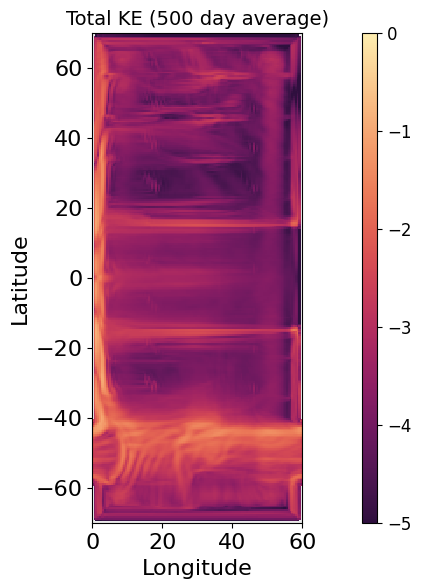

In [105]:
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('Total KE (500 day average)',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.log10(KE_tot),cmap=cmocean.cm.matter_r,vmin=-5,vmax=0,shading='auto') #vmin=0,vmax=1e-1,
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

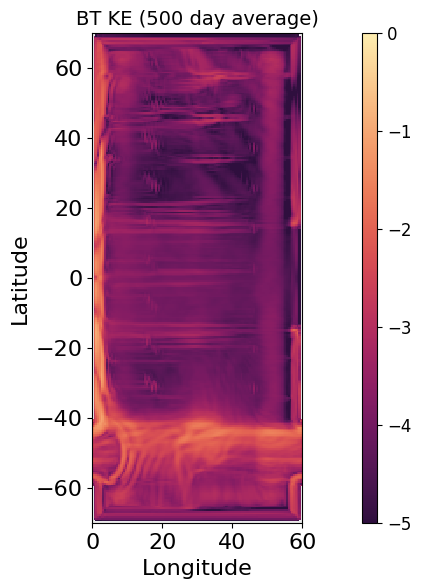

In [106]:
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('BT KE (500 day average)',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.log10(KE_BT_tot),cmap=cmocean.cm.matter_r,vmin=-5,vmax=0,shading='auto') #vmin=0,vmax=1e-1,
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

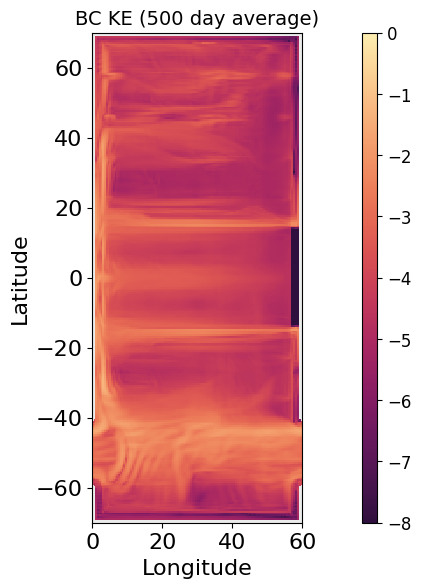

In [107]:
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('BC KE (500 day average)',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.log10(KE_BC_tot),cmap=cmocean.cm.matter_r,vmin=-8,vmax=0,shading='auto') #vmin=0,vmax=1e-1,
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

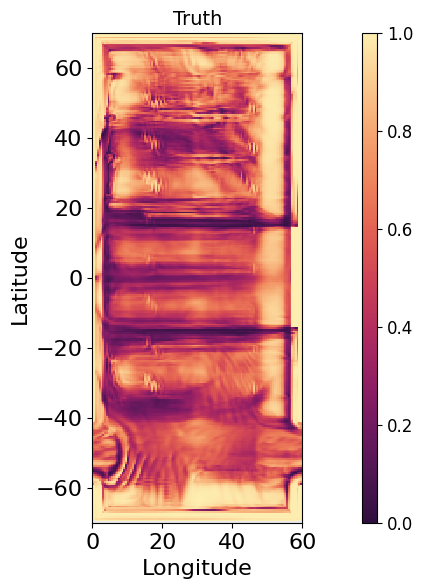

In [108]:
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('Truth',fontsize=14)

plotted =ax1.pcolor(xh,yh,fraction_BT,cmap=cmocean.cm.matter_r,vmin=0,vmax=1,shading='auto') #vmin=0,vmax=1e-1,
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

## Alternative way, using thickness weighted KE model diagnostic.

In [109]:
print(av.KE)
print(av.h)
weightedKE=((av.KE*av.h)/(av.h.sum('zl'))).sum('zl').mean('time')
snapshotKE=((av.KE*av.h)/(av.h.sum('zl'))).sum('zl')[-1,:,:]

<xarray.DataArray 'KE' (time: 400, zl: 15, yh: 280, xh: 120)>
dask.array<concatenate, shape=(400, 15, 280, 120), dtype=float32, chunksize=(100, 15, 280, 120), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 0.25 0.75 1.25 1.75 2.25 ... 58.25 58.75 59.25 59.75
  * yh       (yh) float64 -69.75 -69.25 -68.75 -68.25 ... 68.75 69.25 69.75
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.199e+04 3.2e+04
Attributes:
    long_name:      Layer kinetic energy per unit mass
    units:          m2 s-2
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'h' (time: 400, zl: 15, yh: 280, xh: 120)>
dask.array<concatenate, shape=(400, 15, 280, 120), dtype=float32, chunksize=(100, 15, 280, 120), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 0.25 0.75 1.25 1.75 2.25 

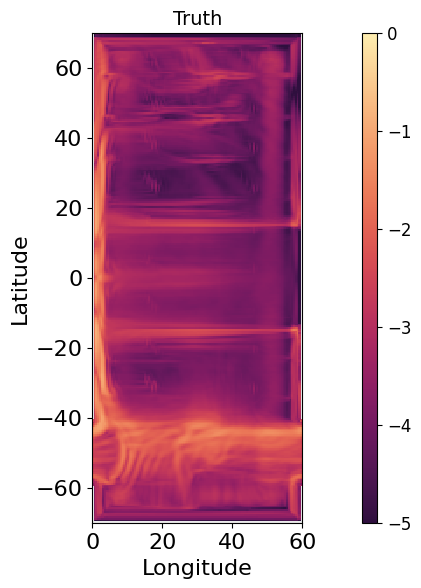

In [110]:
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('Truth',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.log10(weightedKE),cmap=cmocean.cm.matter_r,vmin=-5,vmax=0,shading='auto') #vmin=0,vmax=1e-1,
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

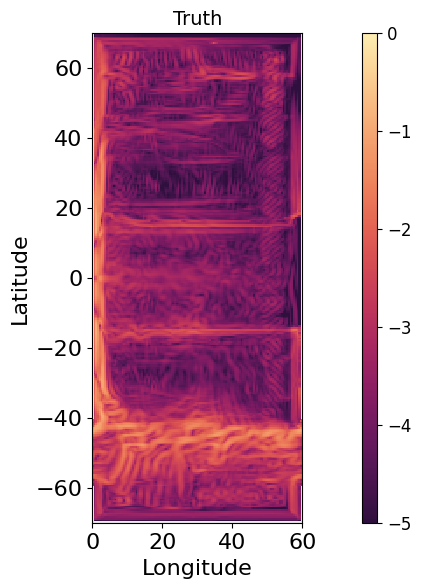

In [111]:
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('Truth',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.log10(snapshotKE),cmap=cmocean.cm.matter_r,vmin=-5,vmax=0,shading='auto') #vmin=0,vmax=1e-1,
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

In [122]:
a=np.array(av['Rd1'][:,240,90])
print(a.shape)
np.nanmean(a)

(400,)


38388.824

In [ ]:
38000*